In [1]:
####################引入头文件
import gc
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from random import choice
random.seed(114514);
get_ipython().run_line_magic('matplotlib', 'inline')
get_ipython().run_line_magic('config', 'InlineBackend.figure_format = "svg"')
from IPython import display
from IPython.display import clear_output as clear

In [2]:
####################返回1和2点之间的距离
def distance(x1, y1, x2, y2):
    return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5
####################返回以1为角点的12,13两条线段成的角度
def degree(x1, y1, x2, y2, x3, y3):
    cos = ((x3 - x1) * (x2 - x1) + (y3 - y1) * (y2 - y1)) / distance(x1, y1, x2, y2) / distance(x1, y1, x3, y3)
    if cos - 1 >= -eps:
        return 0
    elif cos + 1 < eps:
        return math.acos(-1)
    else:
        return math.acos(cos)
####################判断一个内部永远在线段右侧（顺时针旋转）的多边形以1为角点的12,13两条线段成的内角度（与degree不同的是这个角可以>=π）
def truedegree(x1, y1, x2, y2, x3, y3):
    i = degree(x1, y1, x2, y2, x3, y3)
    if cross(x1, y1, x2, y2, x3, y3) < 0:
        i = 2 * math.pi - i
    return i
####################输出射线12与x轴成的角度，值域为[0, 2π]
def zt2pitruedegree(x1, y1, x2, y2):
    if x2 == x1:
        i = 0.5 * math.pi * (y2 - y1) / abs(y2 - y1)
    else:
        i = math.atan((y2 - y1) / (x2 - x1))
    if x2 < x1:
        i += math.pi
    if x2 >= x1 and y2 < y1:
        i += 2 * math.pi
    return i
####################返回以1为共同点的叉积
def cross(x1, y1, x2, y2, x3, y3):
    xd1 = x2 - x1
    yd1 = y2 - y1
    xd2 = x3 - x1
    yd2 = y3 - y1
    return xd1 * yd2 - xd2 * yd1
####################判断两条线段是否相交
def segment(x1, y1, x2, y2, x3, y3, x4, y4):
    #矩形判定
    if(max(x1, x2) - min(x3, x4) >= -eps#矩形1最右端大于矩形2最左端
    and max(x3, x4) - min(x1, x2) >= -eps#矩形2最右端大于矩形1最左端
    and max(y1, y2) - min(y3, y4) >= -eps#矩形1最高端大于矩形2最低端
    and max(y3, y4) - min(y1, y2) >= -eps):#矩形2最高端大于矩形1最低端
        if (cross(x1, y1, x2, y2, x3, y3) * cross(x1, y1, x2, y2, x4, y4) < eps and cross(x3, y3, x4, y4, x1, y1) * cross(x3, y3, x4, y4, x2, y2) < eps):
            d = 1#相交
        else:
            d = 0#不相交
    else:
        d = 0#不相交
    return d
####################sign函数
def sgn(x):
    if x < 0:
        return -1
    elif abs(x) < eps:
        return 0
    else:
        return 1
####################返回边长为a,b,c和为d,e,f的两个三角形的面积之和
def triarea(a, b, c, d, e, f):
    if a + b <= c or a + c <= b or b + c <= a:
        s1 = 0
    else:
        s1 = ((a + b + c) * (a + b - c) * (a + c - b) * (b + c - a)) ** 0.5
    if d + e <= f or d + f <= e or e + f <= d:
        s2 = 0
    else:
        s2 = ((d + e + f) * (d + e - f) * (d + f - e) * (e + f - d)) ** 0.5
    return 0.25 * (s1 + s2)
####################返回四边形质量
def getquality(x1, y1, x2, y2, x3, y3, x4, y4):#顺时针排列四个点
    a = distance(x1, y1, x2, y2)
    b = distance(x2, y2, x3, y3)
    c = distance(x3, y3, x4, y4)
    d = distance(x4, y4, x1, y1)#四条边长
    d1 = truedegree(x1, y1, x4, y4, x2, y2)
    d2 = truedegree(x2, y2, x1, y1, x3, y3)
    d3 = truedegree(x3, y3, x2, y2, x4, y4)
    d4 = 2 * math.pi - d1 - d2 - d3#四个角
    recareasqr = triarea(a, b, distance(x3, y3, x1, y1), distance(x1, y1, x3, y3), c, d) ** 0.5#四边形面积取根号
    qe = ((a / recareasqr) ** sgn(recareasqr - a) * (b / recareasqr) ** sgn(recareasqr - b) * (c / recareasqr) ** sgn(recareasqr - c) * (d / recareasqr) ** sgn(recareasqr - d)) ** 0.25
    qa1 = 1 - abs(d1 * 2 / math.pi - 1)
    qa2 = 1 - abs(d2 * 2 / math.pi - 1)
    qa3 = 1 - abs(d3 * 2 / math.pi - 1)
    qa = 1 - abs(d4 * 2 / math.pi - 1)
    if qa < 0 or qa1 < 0 or qa2 < 0 or qa3 < 0:
        return 0
    else:
        qa = (qa * qa1 * qa2 * qa3) ** 0.25
    return qe * qa
####################判断一个点是否在一个n边形内
#nvert是多边形的顶点个数
#vertx是多边形顶点的x值的列表
#verty是多边形顶点的y值的列表
#(testx, testy)是检测点坐标
def pnpoly(nvert, vertx, verty, testx, testy):
    j = nvert - 1
    result = 0
    for i in range(nvert):
        if verty[j] == verty[i]:
            j = i
            continue
        x = (vertx[j] - vertx[i]) * (testy - verty[i]) / (verty[j] - verty[i]) + vertx[i]
        if ((verty[i] > testy) != (verty[j] > testy)) and (testx < x):
            result = 1 - result#点在多变形内，返回True
        j = i
    return result
####################找出trueseed中最小的角
def findsmallestangle(trueseed):
    minangle = truedegree(trueseed[0][0], trueseed[1][0], trueseed[0][len(trueseed[0]) - 1], trueseed[1][len(trueseed[0]) - 1], trueseed[0][1], trueseed[1][1])#每次循环开始，先设定最小角是第0个点的夹角
    p0 = 0
    for i in range(1, len(trueseed[0])):#找到最小的角，p0记录其序号
        j = truedegree(trueseed[0][i], trueseed[1][i], trueseed[0][i - 1], trueseed[1][i - 1], trueseed[0][(i + 1) % len(trueseed[0])], trueseed[1][(i + 1) % len(trueseed[0])])
        if j < minangle:
            minangle = j
            p0 = i
    return p0
####################设计的选取θ1-3的分段函数：当角0在角1和角2间时返回0，否则返回与两个角射线所成的夹角中较小的那个
def degreepeicewise(angle0, angle1, angle2):
    if angle0 >= angle1 and angle0 < angle2 or angle0 - 2 * math.pi >= angle1 and angle0 - 2 * math.pi < angle2:#在两角内部
        return 0
    a = angle0 - angle2
    while a < 0:
        a += 2 * math.pi
    while a >= 2 * math.pi:
        a -= 2 * math.pi
    b = angle1 - angle0
    while b < 0:
        b += 2 * math.pi
    while b >= 2 * math.pi:
        b -= 2 * math.pi
    return min(a, b)
####################根据得到的p0点给出坐标变换矩阵和state张量
def getinputvars(trueseed, p0, jindu, shuliang):
    state0 = np.zeros(20)#定义出作为输入的n个坐标点未经过变换前组成的状态
    state = np.zeros(26)#定义出作为输入的n个坐标点经过旋转和放缩变换后组成的状态
    state0[0] = trueseed[0][(p0 - 2) % len(trueseed[0])]#右2x
    state0[1] = trueseed[1][(p0 - 2) % len(trueseed[0])]#右2y
    state0[2] = trueseed[0][(p0 + 1) % len(trueseed[0])]#左1x
    state0[3] = trueseed[1][(p0 + 1) % len(trueseed[0])]#左1y
    state0[4] = trueseed[0][(p0 + 2) % len(trueseed[0])]#左2x
    state0[5] = trueseed[1][(p0 + 2) % len(trueseed[0])]#左2y
    x0 = trueseed[0][p0]#最小角点x
    y0 = trueseed[1][p0]#最小角点y
    xr1 = trueseed[0][(p0 - 1) % len(trueseed[0])]#右1x
    yr1 = trueseed[1][(p0 - 1) % len(trueseed[0])]#右1y
    anglejia = truedegree(x0, y0, xr1, yr1, state0[2], state0[3])#真实的夹角
    angler1 = zt2pitruedegree(x0, y0, xr1, yr1)#右手的绝对角度
    anglel1 = zt2pitruedegree(x0, y0, state0[2], state0[3])#左手的绝对角度
    anglemr = angler1 + anglejia / 3#中偏右的绝对角度
    angleml = anglemr + anglejia / 3#中偏左的绝对角度
    if angler1 + anglejia >= anglel1 + math.pi:#过x正轴了
        angleml -= 2 * math.pi
        anglemr -= 2 * math.pi
        angler1 -= 2 * math.pi#经过这一段后，angler1一定小于anglel1
    j = p0 + 2
    while x0 == trueseed[0][j % len(trueseed[0])] and y0 == trueseed[1][j % len(trueseed[0])] or xr1 == trueseed[0][j % len(trueseed[0])] and yr1 == trueseed[1][j % len(trueseed[0])] or state0[2] == trueseed[0][j % len(trueseed[0])] and state0[3] == trueseed[1][j % len(trueseed[0])]:
        j += 1
    j %= len(trueseed[0])
    anglej = zt2pitruedegree(x0, y0, trueseed[0][j], trueseed[1][j])
    disttmp = distance(x0, y0, trueseed[0][j], trueseed[1][j])
    minr = (degreepeicewise(anglej, angler1, anglemr) + mini) * disttmp#右1/3扇形对p0+2点的指标
    minrseq = j
    minm = (degreepeicewise(anglej, anglemr, angleml) + mini) * disttmp
    minmseq = j
    minl = (degreepeicewise(anglej, angleml, anglel1) + mini) * disttmp
    minlseq = j
    k = j
    for i in range(k + 1, k - 3 + len(trueseed[0])):
        j = i % len(trueseed[0])
        if x0 == trueseed[0][j] and y0 == trueseed[1][j] or xr1 == trueseed[0][j] and yr1 == trueseed[1][j] or state0[2] == trueseed[0][j] and state0[3] == trueseed[1][j]:
            continue
        anglej = zt2pitruedegree(x0, y0, trueseed[0][j], trueseed[1][j])
        disttmp = distance(x0, y0, trueseed[0][j], trueseed[1][j])
        if minr > (degreepeicewise(anglej, angler1, anglemr) + mini) * disttmp:
            minr = (degreepeicewise(anglej, angler1, anglemr) + mini) * disttmp
            minrseq = j
        if minm > (degreepeicewise(anglej, anglemr, angleml) + mini) * disttmp:
            minm = (degreepeicewise(anglej, anglemr, angleml) + mini) * disttmp
            minmseq = j
        if minl > (degreepeicewise(anglej, angleml, anglel1) + mini) * disttmp:
            minl = (degreepeicewise(anglej, angleml, anglel1) + mini) * disttmp
            minlseq = j
    state0[14] = trueseed[0][minrseq]#右θx
    state0[15] = trueseed[1][minrseq]#右θy
    state0[16] = trueseed[0][minmseq]#中θx
    state0[17] = trueseed[1][minmseq]#中θy
    state0[18] = trueseed[0][minlseq]#左θx
    state0[19] = trueseed[1][minlseq]#左θy
    d = distance(x0, y0, xr1, yr1)
    A = np.array([[(xr1 - x0) / d, (yr1 - y0) / d, 0], [(y0 - yr1) / d, (xr1 - x0) / d, 0], [0, 0, 1]])#A,B,C,D是变换矩阵
    B = np.array([[1 / d, 0, 0], [0, 1 / d, 0], [0, 0, 1]])
    C = np.array([[1, 0, -x0], [0, 1, -y0], [0, 0, 1]])
    D = np.matmul(A, B)
    D = np.matmul(D, C)
    for i in range(10):
        state[2 * i: 2 * i + 2] = np.dot(D, np.array([state0[2 * i], state0[2 * i + 1], 1]))[: -1]#坐标变换
    tmp = max(1, distance(0, 0, state[6], state[7]) / radius)
    state[14] /= tmp
    state[15] /= tmp
    tmp = max(1, distance(0, 0, state[8], state[9]) / radius)
    state[16] /= tmp
    state[17] /= tmp
    tmp = max(1, distance(0, 0, state[10], state[11]) / radius)
    state[18] /= tmp
    state[19] /= tmp
    state[20] = (x0 - xmin) / xmax
    state[21] = (y0 - ymin) / ymax
    state[22] = (xr1 - xmin) / xmax
    state[23] = (yr1 - ymin) / ymax
    state[24] = jindu#进度
    state[25] = shuliang#数量
    state = torch.FloatTensor(state).unsqueeze(0)#将numpy数组state（维数为0）转为tensor并在0维度处升一维
    return np.matrix(D), state

In [3]:
####################定义MLP类，为决策网络和价值网络的公共部分
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim):
        super().__init__()
        self.fc_1s = nn.Linear(input_dim, hidden_dim1)
        self.fc_1n = nn.Linear(input_dim, hidden_dim1)
        #self.bn_1s = nn.BatchNorm1d(hidden_dim1)
        #self.bn_1n = nn.BatchNorm1d(hidden_dim1)
        self.fc_1n2 = nn.Linear(hidden_dim1, hidden_dim1)
        #self.bn_1n2 = nn.BatchNorm1d(hidden_dim1)

        self.fc_2s = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc_2n = nn.Linear(hidden_dim1, hidden_dim2)
        #self.bn_2s = nn.BatchNorm1d(hidden_dim2)
        #self.bn_2n = nn.BatchNorm1d(hidden_dim2)
        self.fc_2n2 = nn.Linear(hidden_dim2, hidden_dim2)
        #self.bn_2n2 = nn.BatchNorm1d(hidden_dim2)

        self.fc_3s = nn.Linear(hidden_dim2, hidden_dim3)
        self.fc_3n = nn.Linear(hidden_dim2, hidden_dim3)
        #self.bn_3s = nn.BatchNorm1d(hidden_dim3)
        #self.bn_3n = nn.BatchNorm1d(hidden_dim3)
        self.fc_3n2 = nn.Linear(hidden_dim3, hidden_dim3)
        #self.bn_3n2 = nn.BatchNorm1d(hidden_dim3)

        self.fc_4 = nn.Linear(hidden_dim3, output_dim)
    def forward(self, x):
        x1s = self.fc_1s(x)
        x1n = self.fc_1n(x)
        #x1s = self.bn_1s(x1s)
        #x1n = self.bn_1n(x1n)
        x1n = F.leaky_relu(x1n, negative_slope = 0.1)
        x1n = self.fc_1n2(x1n)
        #x1n = self.bn_1n2(x1n)
        x1n = F.leaky_relu(x1n + x1s, negative_slope = 0.1)
        x2s = self.fc_2s(x1n)
        x2n = self.fc_2n(x1n)
        #x2s = self.bn_2s(x2s)
        #x2n = self.bn_2n(x2n)
        x2n = F.leaky_relu(x2n, negative_slope = 0.1)
        x2n = self.fc_2n2(x2n)
        #x2n = self.bn_2n2(x2n)
        x2n = F.leaky_relu(x2n + x2s, negative_slope = 0.1)
        x3s = self.fc_3s(x2n)
        x3n = self.fc_3n(x2n)
        #x3s = self.bn_3s(x3s)
        #x3n = self.bn_3n(x3n)
        x3n = F.leaky_relu(x3n, negative_slope = 0.1)
        x3n = self.fc_3n2(x3n)
        #x3n = self.bn_3n2(x3n)
        x3n = F.leaky_relu(x3n + x3s, negative_slope = 0.1)
        return self.fc_4(x3n)

In [4]:
####################定义ActorCritic类，返回决策网络的预测和价值网络的预测
class ActorCritic(nn.Module):
    def __init__(self, actor, critic):
        super().__init__()
        self.actor = actor
        self.critic = critic
    def forward(self, state):
        action_pred = self.actor(state)
        value_pred = self.critic(state)
        action_pred = 0.75 * torch.tanh(action_pred) + 0.75#限制坐标范围
        #action_pred[:, 1] = (action_pred[:, 1] + 0.1) * 15 / 16
        return action_pred, value_pred

In [5]:
####################首先判断取这个新点（type0）和进行两种消除（type1, type2）合不合法，然后在合法的中取reward高的执行
def judge(trueseed, p0, typesi, new10, new11):
    x0 = trueseed[0][p0]#最小角点x
    y0 = trueseed[1][p0]#最小角点y
    xr1 = trueseed[0][(p0 - 1) % len(trueseed[0])]#右1x
    yr1 = trueseed[1][(p0 - 1) % len(trueseed[0])]#右1y
    xr2 = trueseed[0][(p0 - 2) % len(trueseed[0])]#右2x
    yr2 = trueseed[1][(p0 - 2) % len(trueseed[0])]#右2y
    xl1 = trueseed[0][(p0 + 1) % len(trueseed[0])]#左1x
    yl1 = trueseed[1][(p0 + 1) % len(trueseed[0])]#左1y
    xl2 = trueseed[0][(p0 + 2) % len(trueseed[0])]#左2x
    yl2 = trueseed[1][(p0 + 2) % len(trueseed[0])]#左2y
    reward = -5
    reward_angle = -5
    #首先判断取新点能否成立
    if typesi == 0 and pnpoly(len(trueseed[0]), trueseed[0], trueseed[1], new10, new11):#首先要求新产生的点在多边形内
        flag = False
        for j in range(len(trueseed[0])):#然后要求新产生的点与r1和l1点的连线不与不和r1和l1点连接的所有线段相交
            if not ((xr1 == trueseed[0][j]) and (yr1 == trueseed[1][j]) or (xr1 == trueseed[0][(j + 1) % len(trueseed[0])]) and (yr1 == trueseed[1][(j + 1) % len(trueseed[0])])) and segment(xr1, yr1, new10, new11, trueseed[0][j], trueseed[1][j], trueseed[0][(j + 1) % len(trueseed[0])], trueseed[1][(j + 1) % len(trueseed[0])]):
                flag = True
                break
            if not ((xl1 == trueseed[0][j]) and (yl1 == trueseed[1][j]) or (xl1 == trueseed[0][(j + 1) % len(trueseed[0])]) and (yl1 == trueseed[1][(j + 1) % len(trueseed[0])])) and segment(xl1, yl1, new10, new11, trueseed[0][j], trueseed[1][j], trueseed[0][(j + 1) % len(trueseed[0])], trueseed[1][(j + 1) % len(trueseed[0])]):
                flag = True
                break
        if not flag:#可以取该新点
            reward = getquality(x0, y0, xl1, yl1, new10, new11, xr1, yr1)
            reward_angle = reward * min(truedegree(xl1, yl1, new10, new11, xl2, yl2), math.pi / 3) * min(truedegree(xr1, yr1, xr2, yr2, new10, new11), math.pi / 3)
            return reward, reward_angle
    #然后判断连接r1和l2点能否成立
    if typesi == 1 and abs(truedegree(xr1, yr1, xl2, yl2, x0, y0) - math.pi) >= eps and abs(truedegree(xl2, yl2, xl1, yl1, xr1, yr1) - math.pi) >= eps and abs(truedegree(xl1, yl1, x0, y0, xl2, yl2) - math.pi) >= eps and len(trueseed[0]) > 4 and pnpoly(len(trueseed[0]), trueseed[0], trueseed[1], 0.5 * (xr1 + xl2), 0.5 * (yr1 + yl2)) and not (abs(cross(x0, y0, xr1, yr1, xl1, yl1)) < eps or abs(cross(xl1, yl1, x0, y0, xl2, yl2)) < eps or abs(cross(xl2, yl2, xl1, yl1, xr1, yr1)) < eps or abs(cross(xr1, yr1, xl2, yl2, x0, y0)) < eps):#首先要求连线中点在多边形内且形成四边形
        flag = False
        for j in range(len(trueseed[0])):#然后要求连线不与不和r1和l2点连接的所有线段相交
            if not ((xr1 == trueseed[0][j]) and (yr1 == trueseed[1][j]) or (xr1 == trueseed[0][(j + 1) % len(trueseed[0])]) and (yr1 == trueseed[1][(j + 1) % len(trueseed[0])]) or (xl2 == trueseed[0][j]) and (yl2 == trueseed[1][j]) or (xl2 == trueseed[0][(j + 1) % len(trueseed[0])]) and (yl2 == trueseed[1][(j + 1) % len(trueseed[0])])) and segment(xr1, yr1, xl2, yl2, trueseed[0][j], trueseed[1][j], trueseed[0][(j + 1) % len(trueseed[0])], trueseed[1][(j + 1) % len(trueseed[0])]):
                flag = True
                break
        if not flag:#则可以更新，取该连线
            reward = getquality(xl1, yl1, xl2, yl2, xr1, yr1, x0, y0)
            reward_angle = reward * min(truedegree(xl2, yl2, xr1, yr1, trueseed[0][(p0 + 3) % len(trueseed[0])], trueseed[1][(p0 + 3) % len(trueseed[0])]), math.pi / 3) * min(truedegree(xr1, yr1, xr2, yr2, xl2, yl2), math.pi / 3)
            return reward, reward_angle
    #然后判断连接r2和l1点能否成立
    if typesi == 2 and abs(truedegree(xl1, yl1, x0, y0, xr2, yr2) - math.pi) >= eps and abs(truedegree(xr2, yr2, xl1, yl1, xr1, yr1) - math.pi) >= eps and abs(truedegree(xr1, yr1, xr2, yr2, x0, y0) - math.pi) >= eps and len(trueseed[0]) > 4 and pnpoly(len(trueseed[0]), trueseed[0], trueseed[1], 0.5 * (xr2 + xl1), 0.5 * (yr2 + yl1)) and not (abs(cross(x0, y0, xr1, yr1, xl1, yl1)) < eps or abs(cross(xl1, yl1, x0, y0, xr1, yr1)) < eps or abs(cross(xr1, yr1, xl1, yl1, xr2, yr2)) < eps or abs(cross(xr2, yr2, xr1, yr1, x0, y0)) < eps):#首先要求连线中点在多边形内且形成四边形
        flag = False
        for j in range(len(trueseed[0])):#然后要求连线不与不和r2和l1点连接的所有线段相交
            if not ((xr2 == trueseed[0][j]) and (yr2 == trueseed[1][j]) or (xr2 == trueseed[0][(j + 1) % len(trueseed[0])]) and (yr2 == trueseed[1][(j + 1) % len(trueseed[0])]) or (xl1 == trueseed[0][j]) and (yl1 == trueseed[1][j]) or (xl1 == trueseed[0][(j + 1) % len(trueseed[0])]) and (yl1 == trueseed[1][(j + 1) % len(trueseed[0])])) and segment(xr2, yr2, xl1, yl1, trueseed[0][j], trueseed[1][j], trueseed[0][(j + 1) % len(trueseed[0])], trueseed[1][(j + 1) % len(trueseed[0])]):
                flag = True
                break
        if not flag:#则可以更新，取该连线
            reward = getquality(x0, y0, xl1, yl1, xr2, yr2, xr1, yr1)
            reward_angle = reward * min(truedegree(xl1, yl1, xr2, yr2, xl2, yl2), math.pi / 3) * min(truedegree(xr2, yr2, trueseed[0][(p0 - 3) % len(trueseed[0])], trueseed[1][(p0 - 3) % len(trueseed[0])], xl1, yl1), math.pi / 3)
            return reward, reward_angle
    return -5, -5

In [6]:
####################定义常数、超参数、记录列表
allcount = 0#记录玩的次数
bias = np.zeros((18, 2))
c_puct = 5#UCB权重
clear_every = 500#两次清屏之间玩的次数
cor_step = 0#对应的步数
eps = 0.0000000005#浮点数取等计算误差允许范围5*10^(-10)
hidden_dim1 = 64#隐藏层1自定义维度
hidden_dim2 = 128#隐藏层2自定义维度
hidden_dim3 = 256#隐藏层3自定义维度
input_dim = 26#输入维度
last9count_all = 0#记录使用特权的次数
linesize = 2#画图线条宽度
max_qualities = []#记录搜索过程中每轮的最大质量
max_quality = 0#记录最大quality
max_step = 64#设定最大划分步长数，超过此步数后划分失败，也要结束循环
meanquality = 0#平均质量
mini = 0.01#用于三等分线内部比拼
n_playout = 100000#进行的最大尝试次数
output_dim = 2
pointsize = 20#画图黄点大小
print_every = 100#两次输出之间玩的次数
probs = np.zeros(18)
probssum = 2
bias[8, 0] = 0
bias[8, 1] = 0
bias[17, 0] = 0
bias[17, 1] = 0
probs[8] = 1
probs[17] = 1
for i in range(8):
    bias[i, 0] = 0.15 * math.cos(math.pi / 4 * i)
    bias[i, 1] = 0.15 * math.sin(math.pi / 4 * i)
    bias[i + 9, 0] = bias[i, 0]
    bias[i + 9, 1] = bias[i, 1]
    probs[i] = math.exp(-0.15)
    probs[i + 9] = probs[i]
    probssum += probs[i] * 2
probs /= probssum
qualities = []#记录搜索过程每轮的奖励
quality_threshold = 2#质量上限，达到后结束循环
radius = 3#半径
round_max_quality = 0#每轮的最大质量
wordsize = 10#文字大小
print(bias)
print(probs)

[[ 1.50000000e-01  0.00000000e+00]
 [ 1.06066017e-01  1.06066017e-01]
 [ 9.18485099e-18  1.50000000e-01]
 [-1.06066017e-01  1.06066017e-01]
 [-1.50000000e-01  1.83697020e-17]
 [-1.06066017e-01 -1.06066017e-01]
 [-2.75545530e-17 -1.50000000e-01]
 [ 1.06066017e-01 -1.06066017e-01]
 [ 0.00000000e+00  0.00000000e+00]
 [ 1.50000000e-01  0.00000000e+00]
 [ 1.06066017e-01  1.06066017e-01]
 [ 9.18485099e-18  1.50000000e-01]
 [-1.06066017e-01  1.06066017e-01]
 [-1.50000000e-01  1.83697020e-17]
 [-1.06066017e-01 -1.06066017e-01]
 [-2.75545530e-17 -1.50000000e-01]
 [ 1.06066017e-01 -1.06066017e-01]
 [ 0.00000000e+00  0.00000000e+00]]
[0.05457422 0.05457422 0.05457422 0.05457422 0.05457422 0.05457422
 0.05457422 0.05457422 0.0634062  0.05457422 0.05457422 0.05457422
 0.05457422 0.05457422 0.05457422 0.05457422 0.05457422 0.0634062 ]


In [7]:
class TreeNode:
    def __init__(self, parent, prior_p):
        self._parent = parent
        self._children = {}
        self._n_visits = 0
        self._Q = 0
        self._u = 0
        self._P = prior_p

    def get_value(self):
        self._u = c_puct * self._P * np.sqrt(self._parent._n_visits) / (1 + self._n_visits)
        return self._u + self._Q

    def select(self):
        return max(self._children.items(), key = lambda act_node: act_node[1].get_value())

    def expand(self, action_priors):
        guiyihua = 0
        for i in range(len(action_priors)):
            guiyihua += probs[action_priors[i]]
        for i in range(len(action_priors)):
            #if action_priors[i] not in self._children:
            self._children[action_priors[i]] = TreeNode(self, probs[action_priors[i]] / guiyihua)

    def update(self, leaf_value):
        self._Q = (self._Q * self._n_visits + leaf_value) / (self._n_visits + 1)
        self._n_visits += 1

    def update_recursive(self, leaf_value):
        if self._parent != None:
            self._parent.update_recursive(leaf_value)
        self.update(leaf_value)

In [8]:
def getscore(baseline, low, high):
    if baseline <= low or baseline >= high:
        return 0
    return 0.1

In [9]:
def playout(trueseed, row, col, allcoord, number, sibianxingrecord_all, last9count_all):
    global meanquality, allcount
    sibianxingrecord = np.array(sibianxingrecord_all, dtype = np.int32)
    sibianxingrecord = sibianxingrecord.tolist()
    allcoord2 = ac_save.tolist()#优化前的图案
    node = root
    finish = True
    last9count = last9count_all
    while True:
        p0 = findsmallestangle(trueseed)#获取最小角对应点的序号
        E, state = getinputvars(trueseed, p0, len(trueseed[0]) / initnum, len(sibianxingrecord) / max_step)#获取神经网络输入内容和坐标转换矩阵
        E = E.I#矩阵求逆
        with torch.no_grad():#不更新权重
            action, _ = policyg(state)#获取action预测值
        xtrue = action.numpy()[0, 0]
        ytrue = action.numpy()[0, 1]
        reward1, reward_angle1 = judge(trueseed, p0, 1, 114514, 1919)
        reward2, reward_angle2 = judge(trueseed, p0, 2, 114514, 1919)
        if node._children == {}:#当前节点是叶节点
            action_priors = []
            for i in range(9):
                action = np.dot(E, [[xtrue + bias[i, 0]], [ytrue + bias[i, 1]], [1]])[: -1, 0]#得到的动作函数就是一个长度为2的一维数组
                reward0, reward_angle0 = judge(trueseed, p0, 0, action[0, 0], action[1, 0])#获取应该执行的步骤类型、质量
                if reward1 >= 0 or reward2 >= 0:
                    action_priors.append(i)
                    if (reward_angle0 < reward_angle1 or reward_angle0 < reward_angle2) and reward0 >= 0 and last9count < 1:
                        action_priors.append(i + 9)
                elif reward0 >= 0:
                    action_priors.append(i)
            if action_priors == [] or len(sibianxingrecord) == max_step:#划分非法或达到最大步数
                finish = False
                break
            if node._n_visits == 0:#进行rollout
                action0 = choice(action_priors)
            else:
                node.expand(action_priors)
                action0 = 0
                while not action0 in node._children:
                    action0 += 1
                node = node._children[action0]
        else:
            action0, node = node.select()
        if action0 >= 9:
            last9count += 1
        action = np.dot(E, [[xtrue + bias[action0, 0]], [ytrue + bias[action0, 1]], [1]])[: -1, 0]
        reward0, reward_angle0 = judge(trueseed, p0, 0, action[0, 0], action[1, 0])#获取应该执行的步骤类型、质量
        if reward_angle0 >= reward_angle1 and reward_angle0 >= reward_angle2 or action0 >= 9:
            typesi = 0
            reward = reward0
        elif reward_angle1 >= reward_angle0 and reward_angle1 >= reward_angle2:
            typesi = 1
            reward = reward1
        else:
            typesi = 2
            reward = reward2
        if typesi == 0:#采用了神经网络的划法
            number += 1#编号用数字加1
            sibianxingrecord.append([trueseed[2][(p0 - 1) % len(trueseed[0])], trueseed[2][p0], trueseed[2][(p0 + 1) % len(trueseed[0])], number])#记录四个顶点的编号
            row.append(trueseed[2][(p0 - 1) % len(trueseed[0])])
            col.append(number)#连接新点与右侧点
            row.append(number)
            col.append(trueseed[2][(p0 + 1) % len(trueseed[0])])#连接新点与左侧点
            allcoord[0].append(action[0, 0])
            allcoord[1].append(action[1, 0])#记录新点坐标
            allcoord2[0].append(action[0, 0])
            allcoord2[1].append(action[1, 0])#记录新点坐标
            trueseed[0][p0] = action[0, 0]
            trueseed[1][p0] = action[1, 0]
            trueseed[2][p0] = number#将p0点替换成新点并更新其在trueseed中的编号
        if typesi == 1:#连接r1与l2点
            row.append(trueseed[2][(p0 - 1) % len(trueseed[0])])
            col.append(trueseed[2][(p0 + 2) % len(trueseed[0])])#连接两点
            sibianxingrecord.append([trueseed[2][(p0 - 1) % len(trueseed[0])], trueseed[2][p0], trueseed[2][(p0 + 1) % len(trueseed[0])], trueseed[2][(p0 + 2) % len(trueseed[0])]])#记录四个顶点的编号
            if p0 + 1 < len(trueseed[0]):#不会在删除过程中发生整体移动，直接对着p0处删两次即可
                del trueseed[0][p0]
                del trueseed[1][p0]
                del trueseed[2][p0]
                del trueseed[0][p0]
                del trueseed[1][p0]
                del trueseed[2][p0]
            else:#要删除的第二个点正好是起始点，会发生一次整体移动
                del trueseed[0][p0]
                del trueseed[1][p0]
                del trueseed[2][p0]
                del trueseed[0][0]
                del trueseed[1][0]
                del trueseed[2][0]
        if typesi == 2:#连接r2与l1点
            row.append(trueseed[2][(p0 - 2) % len(trueseed[0])])
            col.append(trueseed[2][(p0 + 1) % len(trueseed[0])])#连接两点
            sibianxingrecord.append([trueseed[2][(p0 - 2) % len(trueseed[0])], trueseed[2][(p0 - 1) % len(trueseed[0])], trueseed[2][p0], trueseed[2][(p0 + 1) % len(trueseed[0])]])#记录四个顶点的编号
            if p0 > 0:
                del trueseed[0][p0]
                del trueseed[1][p0]
                del trueseed[2][p0]
                del trueseed[0][p0 - 1]
                del trueseed[1][p0 - 1]
                del trueseed[2][p0 - 1]
            else:
                tmp = len(trueseed[0]) - 1
                del trueseed[0][tmp]
                del trueseed[1][tmp]
                del trueseed[2][tmp]
                del trueseed[0][0]
                del trueseed[1][0]
                del trueseed[2][0]
        if len(trueseed[0]) == 4:#判定完成条件：len(trueseed[0])在新划分后等于4且四个内角没有一个等于π
            x0 = trueseed[0][0]
            y0 = trueseed[1][0]
            x1 = trueseed[0][1]
            y1 = trueseed[1][1]
            x2 = trueseed[0][2]
            y2 = trueseed[1][2]
            x3 = trueseed[0][3]
            y3 = trueseed[1][3]
            angle0 = truedegree(x0, y0, x3, y3, x1, y1)#0点角度
            angle1 = truedegree(x1, y1, x0, y0, x2, y2)#1点角度
            angle2 = truedegree(x2, y2, x1, y1, x3, y3)#2点角度
            sibianxingrecord.append([trueseed[2][0], trueseed[2][1], trueseed[2][2], trueseed[2][3]])#记录最后四个顶点的编号
            break
    movedall = 0#计算每轮移动次数
    moved = 1
    while movedall < 1000 and moved > 0:
        moved = 0
        for i in range(initnum, len(allcoord[0])):
            connected = []#记录与i点相连的点编号
            smallquality1 = 0#计算局部质量
            smallquality2 = 0
            for j in range(len(row)):
                if i == row[j]:#就是我们要找的那个点
                    connected.append(col[j])
                if i == col[j]:
                    connected.append(row[j])
            x = 0
            y = 0
            for j in range(len(connected)):
                x += allcoord[0][connected[j]]
                y += allcoord[1][connected[j]]
            x /= len(connected)#得到新的i点坐标
            y /= len(connected)
            flag = True
            for j in range(len(connected)):
                for k in range(len(row)):
                    if i != row[k] and i != col[k] and connected[j] != row[k] and connected[j] != col[k] and segment(x, y, allcoord[0][connected[j]], allcoord[1][connected[j]], allcoord[0][row[k]], allcoord[1][row[k]], allcoord[0][col[k]], allcoord[1][col[k]]):
                        flag = False
                        break
                if not flag:
                    break
            if not flag:
                continue
            for j in range(len(sibianxingrecord)):
                if i == sibianxingrecord[j][0]:#该点在这个四边形里
                    smallquality1 += getquality(allcoord[0][sibianxingrecord[j][0]], allcoord[1][sibianxingrecord[j][0]], allcoord[0][sibianxingrecord[j][1]], allcoord[1][sibianxingrecord[j][1]], allcoord[0][sibianxingrecord[j][2]], allcoord[1][sibianxingrecord[j][2]], allcoord[0][sibianxingrecord[j][3]], allcoord[1][sibianxingrecord[j][3]])
                    smallquality2 += getquality(x, y, allcoord[0][sibianxingrecord[j][1]], allcoord[1][sibianxingrecord[j][1]], allcoord[0][sibianxingrecord[j][2]], allcoord[1][sibianxingrecord[j][2]], allcoord[0][sibianxingrecord[j][3]], allcoord[1][sibianxingrecord[j][3]])
                if i == sibianxingrecord[j][1]:
                    smallquality1 += getquality(allcoord[0][sibianxingrecord[j][0]], allcoord[1][sibianxingrecord[j][0]], allcoord[0][sibianxingrecord[j][1]], allcoord[1][sibianxingrecord[j][1]], allcoord[0][sibianxingrecord[j][2]], allcoord[1][sibianxingrecord[j][2]], allcoord[0][sibianxingrecord[j][3]], allcoord[1][sibianxingrecord[j][3]])
                    smallquality2 += getquality(allcoord[0][sibianxingrecord[j][0]], allcoord[1][sibianxingrecord[j][0]], x, y, allcoord[0][sibianxingrecord[j][2]], allcoord[1][sibianxingrecord[j][2]], allcoord[0][sibianxingrecord[j][3]], allcoord[1][sibianxingrecord[j][3]])
                if i == sibianxingrecord[j][2]:
                    smallquality1 += getquality(allcoord[0][sibianxingrecord[j][0]], allcoord[1][sibianxingrecord[j][0]], allcoord[0][sibianxingrecord[j][1]], allcoord[1][sibianxingrecord[j][1]], allcoord[0][sibianxingrecord[j][2]], allcoord[1][sibianxingrecord[j][2]], allcoord[0][sibianxingrecord[j][3]], allcoord[1][sibianxingrecord[j][3]])
                    smallquality2 += getquality(allcoord[0][sibianxingrecord[j][0]], allcoord[1][sibianxingrecord[j][0]], allcoord[0][sibianxingrecord[j][1]], allcoord[1][sibianxingrecord[j][1]], x, y, allcoord[0][sibianxingrecord[j][3]], allcoord[1][sibianxingrecord[j][3]])
                if i == sibianxingrecord[j][3]:
                    smallquality1 += getquality(allcoord[0][sibianxingrecord[j][0]], allcoord[1][sibianxingrecord[j][0]], allcoord[0][sibianxingrecord[j][1]], allcoord[1][sibianxingrecord[j][1]], allcoord[0][sibianxingrecord[j][2]], allcoord[1][sibianxingrecord[j][2]], allcoord[0][sibianxingrecord[j][3]], allcoord[1][sibianxingrecord[j][3]])
                    smallquality2 += getquality(allcoord[0][sibianxingrecord[j][0]], allcoord[1][sibianxingrecord[j][0]], allcoord[0][sibianxingrecord[j][1]], allcoord[1][sibianxingrecord[j][1]], allcoord[0][sibianxingrecord[j][2]], allcoord[1][sibianxingrecord[j][2]], x, y)
            if smallquality2 >= smallquality1 + 10000000 * eps:
                allcoord[0][i] = x
                allcoord[1][i] = y
                moved += 1
        movedall += moved
    quality = 0
    for i in range(len(sibianxingrecord)):
        quality += getquality(allcoord[0][sibianxingrecord[i][0]], allcoord[1][sibianxingrecord[i][0]], allcoord[0][sibianxingrecord[i][1]], allcoord[1][sibianxingrecord[i][1]], allcoord[0][sibianxingrecord[i][2]], allcoord[1][sibianxingrecord[i][2]], allcoord[0][sibianxingrecord[i][3]], allcoord[1][sibianxingrecord[i][3]])
    quality *= finish / max(len(sibianxingrecord), 1)
    quality2 = quality
    meanquality = (meanquality * allcount + quality) / (allcount + 1)
    allcount += 1
    quality2 += getscore(len(sibianxingrecord), 34, 38)
    if last9count - last9count_all > 0 and quality >= meanquality:
        quality2 += 0.2
    node.update_recursive(quality2)
    return len(sibianxingrecord), quality, trueseed, row, col, allcoord, allcoord2

episode: 100 mean quality: 0.6694086784038976 present mean quality: 0.6831785614276977 round max quality: 0.7973539636509945 max quality: 0.8037002918790674 cor step: 35
0 [0.15 0.  ] : 19 0.738771415369723
1 [0.10606602 0.10606602] : 17 0.6835189518702958
2 [9.18485099e-18 1.50000000e-01] : 19 0.72913036447649
3 [-0.10606602  0.10606602] : 22 0.7710391815228433
4 [-1.5000000e-01  1.8369702e-17] : 22 0.7735753423784394
5 [-0.10606602 -0.10606602] : 16 0.6262050720347214
6 [-2.7554553e-17 -1.5000000e-01] : 19 0.7204150593350903
7 [ 0.10606602 -0.10606602] : 14 0.6182262271166363
8 [0. 0.] : 24 0.7535408452301726
episode: 200 mean quality: 0.6696251007618587 present mean quality: 0.6904016471260204 round max quality: 0.8006695505387478 max quality: 0.8037002918790674 cor step: 35
0 [0.15 0.  ] : 33 0.7287306819432101
1 [0.10606602 0.10606602] : 29 0.7182047038742716
2 [9.18485099e-18 1.50000000e-01] : 30 0.7191825628799792
3 [-0.10606602  0.10606602] : 31 0.7380721270863037
4 [-1.5000000

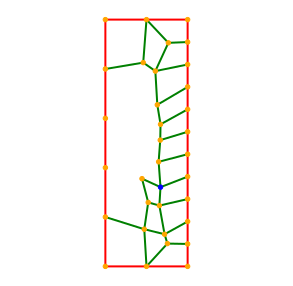

Your selection is(-1 and -2 continue, or choose action):76


IndexError: index 76 is out of bounds for axis 0 with size 18

In [10]:
##### 从文件Trueseed.txt中读取了trueseed，并根据此生成了将其按顺时针顺序连接的用于记录邻接信息的列表row，col和总坐标allcoord
root = TreeNode(None, 1)
actorg = MLP(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim)
criticg = MLP(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, 1)
policyg = ActorCritic(actorg, criticg)
os.system("delete2.bat")
os.makedirs("results-mcts")
os.makedirs("results-mcts-ls")
weight = torch.load("weight 5000.w")
policyg.load_state_dict(weight["state_dict"])
f = open("Trueseed.txt")
trueseed = [[], [], []]
line = f.readline()
while line:
    line = line.strip("\n")
    line = line.split(" ")
    line_read = np.array(line)
    trueseed[0].append(float(line_read[0]))
    trueseed[1].append(float(line_read[1]))
    line = f.readline()
f.close()
number = -1
row = []
col = []
allcoord = [[], []]
xmin = trueseed[0][0]
xmax = trueseed[0][0]
ymin = trueseed[1][0]
ymax = trueseed[1][0]
for i in range(len(trueseed[0])):
    number += 1
    trueseed[2].append(number)
    row.append(number)
    col.append(number + 1)
    allcoord[0].append(trueseed[0][i])
    allcoord[1].append(trueseed[1][i])
    xmin = min(xmin, trueseed[0][i])
    xmax = max(xmax, trueseed[0][i])
    ymin = min(ymin, trueseed[1][i])
    ymax = max(ymax, trueseed[1][i])
print(xmin, xmax, ymin, ymax)
xmax -= xmin
ymax -= ymin
col[len(col) - 1] = 0#首尾相连
ts1_save = np.array(trueseed[: -1])#用数组保存，因为列表赋值后修改后一项前一项也跟着会被修改
ts2_save = np.array(trueseed[2], dtype = np.int32)
rw_save = np.array(row, dtype = np.int32)
cl_save = np.array(col, dtype = np.int32)
ac_save = np.array(allcoord)
number_save = number
initnum = len(trueseed[0])
sibianxingrecord_all = []
####################主循环部分
while True:#大循环
    for episode in range(1, n_playout + 1):
        row = rw_save.tolist()
        col = cl_save.tolist()
        allcoord = ac_save.tolist()
        number = number_save#将用数组保存的信息再转回到列表中
        trueseed = ts1_save.tolist()
        trueseed.append(ts2_save.tolist())#赋值给被修改的trueseed列表
        step, quality, trueseed, row, col, allcoord, allcoord_yuan = playout(trueseed, row, col, allcoord, number, sibianxingrecord_all, last9count_all)#玩一次
        qualities.append(quality)#记录质量
        if quality > round_max_quality:
            round_max_quality = quality
        if quality > max_quality:
            max_quality = quality
            cor_step = step
            #max_trueseed = trueseed
            max_row = row
            max_col = col
            max_allcoord_yuan = allcoord_yuan
            max_allcoord = allcoord
            ####################存储到Row、Col、Allcoord中并输出最终划分结果
            plt.figure(figsize=(5, 5))
            #plt.title("Mesh Result")
            plt.axis("equal")
            #plt.grid()
            for i in range(initnum):
                plt.plot([max_allcoord_yuan[0][max_row[i]], max_allcoord_yuan[0][max_col[i]]], [max_allcoord_yuan[1][max_row[i]], max_allcoord_yuan[1][max_col[i]]], linewidth = linesize, color = 'red')
            for i in range(initnum, len(max_row)):
                plt.plot([max_allcoord_yuan[0][max_row[i]], max_allcoord_yuan[0][max_col[i]]], [max_allcoord_yuan[1][max_row[i]], max_allcoord_yuan[1][max_col[i]]], linewidth = linesize, color = 'green')
            for i in range(len(max_allcoord_yuan[0])):
                plt.scatter(max_allcoord_yuan[0][i], max_allcoord_yuan[1][i], s = pointsize, color = "orange", zorder = 5)
            plt.xticks([])
            plt.yticks([])
            plt.axis("off")
            plt.savefig("results-mcts/" + str(max_quality) + " " + str(cor_step) + ".eps", bbox_inches = "tight", transparent = True)
            plt.figure(figsize=(5, 5))
            #plt.title("Mesh Result")
            plt.axis("equal")
            #plt.grid()
            for i in range(initnum):
                plt.plot([max_allcoord[0][max_row[i]], max_allcoord[0][max_col[i]]], [max_allcoord[1][max_row[i]], max_allcoord[1][max_col[i]]], linewidth = linesize, color = 'red')
            for i in range(initnum, len(max_row)):
                plt.plot([max_allcoord[0][max_row[i]], max_allcoord[0][max_col[i]]], [max_allcoord[1][max_row[i]], max_allcoord[1][max_col[i]]], linewidth = linesize, color = 'green')
            for i in range(len(max_allcoord[0])):
                plt.scatter(max_allcoord[0][i], max_allcoord[1][i], s = pointsize, color = "orange", zorder = 5)
            plt.xticks([])
            plt.yticks([])
            plt.axis("off")
            plt.savefig("results-mcts-ls/" + str(max_quality) + " " + str(cor_step) + ".eps", bbox_inches = "tight", transparent = True)
            ####################输出当前剩余的边界
            #plt.figure(figsize=(5, 5))
            #plt.title("Trueseed Situation")
            #plt.axis("equal")
            #plt.grid()
            #for i in range(initnum):
            #    plt.plot([max_allcoord[0][max_row[i]], max_allcoord[0][max_col[i]]], [max_allcoord[1][max_row[i]], max_allcoord[1][max_col[i]]], linewidth = linesize, color = 'red')
            #for i in range(len(max_trueseed[0])):
            #    plt.plot([max_trueseed[0][i], max_trueseed[0][(i + 1) % len(max_trueseed[0])]], [max_trueseed[1][i], max_trueseed[1][(i + 1) % len(max_trueseed[0])]], linewidth = linesize, color = 'blue')
            #    plt.scatter(max_trueseed[0][i], max_trueseed[1][i], s = pointsize, color = "orange", zorder = 5)
            plt.pause(1)#暂停1秒
            display.clear_output(wait = True)#清屏
        if max_quality >= quality_threshold:
            print("reached quality threshold with a quality of", max_quality, "in", episode, "episodes")
            break
        if episode % print_every == 0:#每经过print_every轮后输出此轮搜索的平均质量和最大质量
            print("episode:", episode,"mean quality:", meanquality, "present mean quality:", np.mean(qualities[-100:]), "round max quality:", round_max_quality, "max quality:", max_quality, "cor step:", cor_step)
            for i in root._children:
                print(i, bias[i, :], ":", root._children[i]._n_visits, root._children[i]._Q)
            max_qualities.append(round_max_quality)
            round_max_quality = 0
            if episode % clear_every == 0:
                row = rw_save.tolist()
                col = cl_save.tolist()
                allcoord = ac_save.tolist()
                trueseed = ts1_save.tolist()
                trueseed.append(ts2_save.tolist())#赋值给被修改的trueseed列表
                p0 = findsmallestangle(trueseed)#获取最小角对应点的序号
                E, state = getinputvars(trueseed, p0, len(trueseed[0]) / initnum, len(sibianxingrecord_all) / max_step)#获取神经网络输入内容和坐标转换矩阵
                E = E.I
                with torch.no_grad():#不更新权重
                    action, _ = policyg(state)#获取action预测值
                print(state, action)
                plt.figure(figsize=(5, 5))
                plt.axis("equal")
                for i in range(initnum):
                    plt.plot([allcoord[0][row[i]], allcoord[0][col[i]]], [allcoord[1][row[i]], allcoord[1][col[i]]], linewidth = linesize, color = 'red')
                for i in range(initnum, len(row)):
                    plt.plot([allcoord[0][row[i]], allcoord[0][col[i]]], [allcoord[1][row[i]], allcoord[1][col[i]]], linewidth = linesize, color = 'green')
                for i in range(len(allcoord[0])):
                    if allcoord[0][i] == trueseed[0][p0] and allcoord[1][i] == trueseed[1][p0]:
                        plt.scatter(allcoord[0][i], allcoord[1][i], s = pointsize, color = "blue", zorder = 5)
                    else:
                        plt.scatter(allcoord[0][i], allcoord[1][i], s = pointsize, color = "orange", zorder = 5)
                plt.xticks([])
                plt.yticks([])
                plt.axis("off")
                plt.show()
                move = int(input("Your selection is(-1 and -2 continue, or choose action):"))
                xtrue = action.numpy()[0, 0]
                ytrue = action.numpy()[0, 1]
                reward1, reward_angle1 = judge(trueseed, p0, 1, 114514, 1919)
                reward2, reward_angle2 = judge(trueseed, p0, 2, 114514, 1919)
                if move != -1 and move != -2:
                    while True:
                        action = np.dot(E, [[xtrue + bias[move, 0]], [ytrue + bias[move, 1]], [1]])[: -1, 0]
                        reward0, reward_angle0 = judge(trueseed, p0, 0, action[0, 0], action[1, 0])#获取应该执行的步骤类型、质量
                        if reward_angle0 >= reward_angle1 and reward_angle0 >= reward_angle2 or move >= 9:
                            typesi = 0
                            reward = reward0
                        elif reward_angle1 >= reward_angle0 and reward_angle1 >= reward_angle2:
                            typesi = 1
                            reward = reward1
                        else:
                            typesi = 2
                            reward = reward2
                        print(typesi, reward_angle0, reward_angle1, reward_angle2)
                        move2 = int(input("Your selection is(-2 confirm, -1 continue, or choose action again):"))
                        if move2 == -1 or move2 == -2:
                            break
                        move = move2
                    if move2 == -2:
                        if move >= 9:
                            last9count_all += 1
                        break
                clear()#清除episode信息
    if typesi == 0:#采用了神经网络的划法
        number_save += 1#编号用数字加1
        sibianxingrecord_all.append([trueseed[2][(p0 - 1) % len(trueseed[0])], trueseed[2][p0], trueseed[2][(p0 + 1) % len(trueseed[0])], number_save])#记录四个顶点的编号
        row.append(trueseed[2][(p0 - 1) % len(trueseed[0])])
        col.append(number_save)#连接新点与右侧点
        row.append(number_save)
        col.append(trueseed[2][(p0 + 1) % len(trueseed[0])])#连接新点与左侧点
        allcoord[0].append(action[0, 0])
        allcoord[1].append(action[1, 0])#记录新点坐标
        trueseed[0][p0] = action[0, 0]
        trueseed[1][p0] = action[1, 0]
        trueseed[2][p0] = number_save#将p0点替换成新点并更新其在trueseed中的编号
    if typesi == 1:#连接r1与l2点
        row.append(trueseed[2][(p0 - 1) % len(trueseed[0])])
        col.append(trueseed[2][(p0 + 2) % len(trueseed[0])])#连接两点
        sibianxingrecord_all.append([trueseed[2][(p0 - 1) % len(trueseed[0])], trueseed[2][p0], trueseed[2][(p0 + 1) % len(trueseed[0])], trueseed[2][(p0 + 2) % len(trueseed[0])]])#记录四个顶点的编号
        if p0 + 1 < len(trueseed[0]):#不会在删除过程中发生整体移动，直接对着p0处删两次即可
            del trueseed[0][p0]
            del trueseed[1][p0]
            del trueseed[2][p0]
            del trueseed[0][p0]
            del trueseed[1][p0]
            del trueseed[2][p0]
        else:#要删除的第二个点正好是起始点，会发生一次整体移动
            del trueseed[0][p0]
            del trueseed[1][p0]
            del trueseed[2][p0]
            del trueseed[0][0]
            del trueseed[1][0]
            del trueseed[2][0]
    if typesi == 2:#连接r2与l1点
        row.append(trueseed[2][(p0 - 2) % len(trueseed[0])])
        col.append(trueseed[2][(p0 + 1) % len(trueseed[0])])#连接两点
        sibianxingrecord_all.append([trueseed[2][(p0 - 2) % len(trueseed[0])], trueseed[2][(p0 - 1) % len(trueseed[0])], trueseed[2][p0], trueseed[2][(p0 + 1) % len(trueseed[0])]])#记录四个顶点的编号
        if p0 > 0:
            del trueseed[0][p0]
            del trueseed[1][p0]
            del trueseed[2][p0]
            del trueseed[0][p0 - 1]
            del trueseed[1][p0 - 1]
            del trueseed[2][p0 - 1]
        else:
            tmp = len(trueseed[0]) - 1
            del trueseed[0][tmp]
            del trueseed[1][tmp]
            del trueseed[2][tmp]
            del trueseed[0][0]
            del trueseed[1][0]
            del trueseed[2][0]
    if len(trueseed[0]) == 4:#判定完成条件：len(trueseed[0])在新划分后等于4且四个内角没有一个等于π
        x0 = trueseed[0][0]
        y0 = trueseed[1][0]
        x1 = trueseed[0][1]
        y1 = trueseed[1][1]
        x2 = trueseed[0][2]
        y2 = trueseed[1][2]
        x3 = trueseed[0][3]
        y3 = trueseed[1][3]
        angle0 = truedegree(x0, y0, x3, y3, x1, y1)#0点角度
        angle1 = truedegree(x1, y1, x0, y0, x2, y2)#1点角度
        angle2 = truedegree(x2, y2, x1, y1, x3, y3)#2点角度
        sibianxingrecord_all.append([trueseed[2][0], trueseed[2][1], trueseed[2][2], trueseed[2][3]])#记录最后四个顶点的编号
        break
    ts1_save = np.array(trueseed[: -1])#用数组保存，因为列表赋值后修改后一项前一项也跟着会被修改
    ts2_save = np.array(trueseed[2], dtype = np.int32)
    rw_save = np.array(row, dtype = np.int32)
    cl_save = np.array(col, dtype = np.int32)
    ac_save = np.array(allcoord)
    tempcount = []
    for i in root._children:
        if i != move:
            tempcount.append(i)
    for i in tempcount:
        del root._children[i]
    root = root._children[move]
    root._parents = None
    gc.collect()
    clear()
moved = 1
while moved > 0:
    moved = 0
    for i in range(initnum, len(allcoord[0])):
        connected = []#记录与i点相连的点编号
        smallquality1 = 0#计算局部质量
        smallquality2 = 0
        for j in range(len(row)):
            if i == row[j]:#就是我们要找的那个点
                connected.append(col[j])
            if i == col[j]:
                connected.append(row[j])
        x = 0
        y = 0
        for j in range(len(connected)):
            x += allcoord[0][connected[j]]
            y += allcoord[1][connected[j]]
        x /= len(connected)#得到新的i点坐标
        y /= len(connected)
        flag = True
        for j in range(len(connected)):
            for k in range(len(row)):
                if i != row[k] and i != col[k] and connected[j] != row[k] and connected[j] != col[k] and segment(x, y, allcoord[0][connected[j]], allcoord[1][connected[j]], allcoord[0][row[k]], allcoord[1][row[k]], allcoord[0][col[k]], allcoord[1][col[k]]):
                    flag = False
                    break
            if not flag:
                break
        if not flag:
            continue
        for j in range(len(sibianxingrecord_all)):
            if i == sibianxingrecord_all[j][0]:#该点在这个四边形里
                smallquality1 += getquality(allcoord[0][sibianxingrecord_all[j][0]], allcoord[1][sibianxingrecord_all[j][0]], allcoord[0][sibianxingrecord_all[j][1]], allcoord[1][sibianxingrecord_all[j][1]], allcoord[0][sibianxingrecord_all[j][2]], allcoord[1][sibianxingrecord_all[j][2]], allcoord[0][sibianxingrecord_all[j][3]], allcoord[1][sibianxingrecord_all[j][3]])
                smallquality2 += getquality(x, y, allcoord[0][sibianxingrecord_all[j][1]], allcoord[1][sibianxingrecord_all[j][1]], allcoord[0][sibianxingrecord_all[j][2]], allcoord[1][sibianxingrecord_all[j][2]], allcoord[0][sibianxingrecord_all[j][3]], allcoord[1][sibianxingrecord_all[j][3]])
            if i == sibianxingrecord_all[j][1]:
                smallquality1 += getquality(allcoord[0][sibianxingrecord_all[j][0]], allcoord[1][sibianxingrecord_all[j][0]], allcoord[0][sibianxingrecord_all[j][1]], allcoord[1][sibianxingrecord_all[j][1]], allcoord[0][sibianxingrecord_all[j][2]], allcoord[1][sibianxingrecord_all[j][2]], allcoord[0][sibianxingrecord_all[j][3]], allcoord[1][sibianxingrecord_all[j][3]])
                smallquality2 += getquality(allcoord[0][sibianxingrecord_all[j][0]], allcoord[1][sibianxingrecord_all[j][0]], x, y, allcoord[0][sibianxingrecord_all[j][2]], allcoord[1][sibianxingrecord_all[j][2]], allcoord[0][sibianxingrecord_all[j][3]], allcoord[1][sibianxingrecord_all[j][3]])
            if i == sibianxingrecord_all[j][2]:
                smallquality1 += getquality(allcoord[0][sibianxingrecord_all[j][0]], allcoord[1][sibianxingrecord_all[j][0]], allcoord[0][sibianxingrecord_all[j][1]], allcoord[1][sibianxingrecord_all[j][1]], allcoord[0][sibianxingrecord_all[j][2]], allcoord[1][sibianxingrecord_all[j][2]], allcoord[0][sibianxingrecord_all[j][3]], allcoord[1][sibianxingrecord_all[j][3]])
                smallquality2 += getquality(allcoord[0][sibianxingrecord_all[j][0]], allcoord[1][sibianxingrecord_all[j][0]], allcoord[0][sibianxingrecord_all[j][1]], allcoord[1][sibianxingrecord_all[j][1]], x, y, allcoord[0][sibianxingrecord_all[j][3]], allcoord[1][sibianxingrecord_all[j][3]])
            if i == sibianxingrecord_all[j][3]:
                smallquality1 += getquality(allcoord[0][sibianxingrecord_all[j][0]], allcoord[1][sibianxingrecord_all[j][0]], allcoord[0][sibianxingrecord_all[j][1]], allcoord[1][sibianxingrecord_all[j][1]], allcoord[0][sibianxingrecord_all[j][2]], allcoord[1][sibianxingrecord_all[j][2]], allcoord[0][sibianxingrecord_all[j][3]], allcoord[1][sibianxingrecord_all[j][3]])
                smallquality2 += getquality(allcoord[0][sibianxingrecord_all[j][0]], allcoord[1][sibianxingrecord_all[j][0]], allcoord[0][sibianxingrecord_all[j][1]], allcoord[1][sibianxingrecord_all[j][1]], allcoord[0][sibianxingrecord_all[j][2]], allcoord[1][sibianxingrecord_all[j][2]], x, y)
        if smallquality2 > smallquality1:
            allcoord[0][i] = x
            allcoord[1][i] = y
            moved += 1
quality = 0
for i in range(len(sibianxingrecord_all)):
    quality += getquality(allcoord[0][sibianxingrecord_all[i][0]], allcoord[1][sibianxingrecord_all[i][0]], allcoord[0][sibianxingrecord_all[i][1]], allcoord[1][sibianxingrecord_all[i][1]], allcoord[0][sibianxingrecord_all[i][2]], allcoord[1][sibianxingrecord_all[i][2]], allcoord[0][sibianxingrecord_all[i][3]], allcoord[1][sibianxingrecord_all[i][3]])
quality /= max(len(sibianxingrecord_all), 1)
####################存储到Row、Col、Allcoord中并输出最终划分结果
plt.figure(figsize=(5, 5))
plt.axis("equal")
for i in range(initnum):
    plt.plot([allcoord[0][row[i]], allcoord[0][col[i]]], [allcoord[1][row[i]], allcoord[1][col[i]]], linewidth = linesize, color = 'red')
for i in range(initnum, len(row)):
    plt.plot([allcoord[0][row[i]], allcoord[0][col[i]]], [allcoord[1][row[i]], allcoord[1][col[i]]], linewidth = linesize, color = 'green')
for i in range(len(allcoord[0])):
    plt.scatter(allcoord[0][i], allcoord[1][i], s = pointsize, color = "orange", zorder = 5)
plt.xticks([])
plt.yticks([])
plt.axis("off")
plt.savefig("results-mcts-ls/final " + str(quality) + " " + str(cor_step) + ".eps", bbox_inches = "tight", transparent = True)